In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import os
import warnings

warnings.filterwarnings("ignore")  # 경고 메시지를 무시하고 숨긴다.

In [ ]:
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

## Load data

In [ ]:
holi = pd.read_csv('./holiday.csv').drop(['Unnamed: 0'],axis=1)
holi.rename(columns={'날짜':'base_date','휴일':'holidays'},inplace=True)

from datetime import datetime, timedelta
final = pd.DataFrame()

def date_range(start, end):
    start = datetime.strptime(start, "%Y-%m-%d")
    end = datetime.strptime(end, "%Y-%m-%d")
    dates = [(start + timedelta(days=i)).strftime("%Y-%m-%d") for i in range((end-start).days+1)]
    return dates

dates = date_range("2018-01-01", "2021-06-30")
final['base_date'] = dates

final = pd.merge(final,holi,on='base_date',how='outer')
final = final.fillna(0).drop(['휴일요일'],axis=1).set_index('base_date')
final = pd.get_dummies(final).drop(['holidays_0'],axis=1).reset_index()
date = final['base_date'].astype(str)

df = pd.DataFrame()
for i in range(42):
    df = pd.concat([df,final],axis=0,ignore_index=True)

date = df['base_date']
df = df.drop(['base_date'],axis=1)

special_days = list(df.columns)
df[special_days] = df[special_days].apply(lambda x: x.map({0: "-", 1: x.name})).astype("category")

# print(df)

In [ ]:
data = pd.read_csv('./minmax.csv').drop(['Unnamed: 0'],axis=1)
data["base_date"] = pd.to_datetime(data["base_date"])

# add time index
data['time_idx'] = data['base_date'].dt.date.apply(lambda x : len(date_range("2018-01-01",str(x))))
data["time_idx"] -= data["time_idx"].min()
# data = data.set_index('base_date')

# add additional features
data["day"] = data.base_date.dt.day.astype(str).astype("category") 
data["month"] = data.base_date.dt.month.astype(str).astype("category") 
data["year"] = data.base_date.dt.year.astype(str).astype("category")  # categories는 문자열(strings)을 가지고 있다.
data["base_date"] = data['base_date'].astype(str)
data["log_df0_em_g"] = np.log(data.df0_em_g + 1e-8)
data["df0_em_g_by_reg"] = data.groupby(["time_idx", "reg"], observed=True).df0_em_g.transform("mean")

data = pd.concat([data,df],axis=1)
data

,base_date,df0_em_cnt,df0_em_g,df0_pay_amt,df4_use_cnt,df4_use_amt,df21_resd_pop_cnt,df21_work_pop_cnt,df21_visit_pop_cnt,df22_resd_pop_cnt,...,holidays_삼일절,holidays_설날,holidays_어린이날,holidays_임시공휴일,holidays_전국동시지방선거,holidays_제21대 국회의원선거,holidays_제헌절,holidays_추석,holidays_한글날,holidays_현충일
0,2018-01-01,0.009110,0.123399,0.009457,0.170392,0.073857,0.010516,0.070210,0.232985,0.101270,...,-,-,-,-,-,-,-,-,-,-
1,2018-01-02,0.009110,0.133000,0.009457,0.170392,0.079712,0.010516,0.093245,0.197764,0.106990,...,-,-,-,-,-,-,-,-,-,-
2,2018-01-03,0.009038,0.101959,0.009457,0.178875,0.083293,0.010517,0.092140,0.188185,0.094755,...,-,-,-,-,-,-,-,-,-,-
3,2018-01-04,0.009117,0.112596,0.009457,0.165867,0.063659,0.010516,0.094069,0.196914,0.093943,...,-,-,-,-,-,-,-,-,-,-
4,2018-01-05,0.009073,0.096679,0.009457,0.172466,0.131549,0.010517,0.090419,0.193739,0.089712,...,-,-,-,-,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53629,2021-06-26,0.009080,0.061644,0.009457,0.092059,0.063314,0.010517,0.015124,0.051227,0.000018,...,-,-,-,-,-,-,-,-,-,-
53630,2021-06-27,0.009118,0.071670,0.009457,0.087723,0.041086,0.010517,0.013634,0.047576,0.000014,...,-,-,-,-,-,-,-,-,-,-
53631,2021-06-28,0.009070,0.069124,0.009457,0.075940,0.033842,0.010516,0.019644,0.046073,0.000012,...,-,-,-,-,-,-,-,-,-,-
53632,2021-06-29,0.009081,0.065050,0.009457,0.086781,0.040716,0.010517,0.019553,0.044960,0.000017,...,-,-,-,-,-,-,-,-,-,-


In [ ]:
len(data['time_idx'].unique())

1277

In [ ]:
data['reg'] = data['reg'].astype('category')
data['base_date'] = pd.to_datetime(data['base_date'])
# print(data.dtypes)

### Create dataset and dataloaders

In [ ]:
max_prediction_length = 62   # 62일 예측
max_encoder_length = 1277 # 1277일 사용
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="df0_em_g",
    group_ids=["reg"],
    min_encoder_length=max_encoder_length // 2,  
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["reg"],
    time_varying_known_categoricals=["special_days", "month","year","day"],
    variable_groups={"special_days": special_days}, 
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "df0_em_g",
        "log_df0_em_g",
        "df0_em_g_by_reg",
    ],
    target_normalizer=GroupNormalizer(
        groups=["reg"], transformation="softplus"
    ),  
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
)

validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=1)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=1)

## Create baseline model

## Train the Temporal Fusion Transformer

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.1 K 
3  | prescalers                         | ModuleDict                      | 128   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.9 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 3.9 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.8 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm 

suggested learning rate: 0.08709635899560807


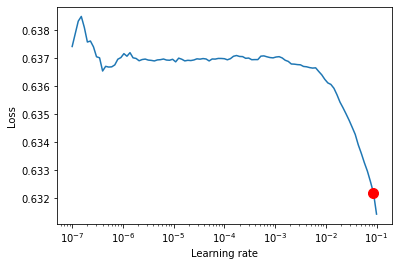

In [ ]:
# 최적 학습률 찾기
res = trainer.tuner.lr_find(
    model=tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=1e-1,
    min_lr=1e-7,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [ ]:
early_stop_callback = EarlyStopping(monitor="val_loss", patience=7, verbose=False, mode="min") 
lr_logger = LearningRateMonitor()  
logger = TensorBoardLogger("lightning_logs")  


pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=1,
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.0001,
    hidden_size=16, 
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8, 
    output_size=7,  
    loss=QuantileLoss(),
    reduce_on_plateau_patience=10,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores


Number of parameters in network: 22.9k


### Train model

In [ ]:
# fit network
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.1 K 
3  | prescalers                         | ModuleDict                      | 128   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.9 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 3.9 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.8 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm 

Global seed set to 42


Epoch 42: 100%|██████████| 31/31 [00:53<00:00,  1.74s/it, loss=0.0056, v_num=16, val_loss=0.00628, train_loss_step=0.00557, train_loss_epoch=0.0057]


### Hyperparameter tuning

In [ ]:
# import pickle
    
# from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# # create study
# study = optimize_hyperparameters(
#     train_dataloader,
#     val_dataloader,
#     model_path="optuna_test",
#     n_trials=100,
#     max_epochs=50,
#     gradient_clip_val_range=(0.01, 1.0),
#     hidden_size_range=(8, 128),
#     hidden_continuous_size_range=(8, 128),
#     attention_head_size_range=(1, 4),
#     learning_rate_range=(0.001, 0.1),
#     dropout_range=(0.1, 0.3),
#     trainer_kwargs=dict(limit_train_batches=30),
#     reduce_on_plateau_patience=4,
#     use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
# )

# with open("test_study.pkl", "wb") as fout:
#     pickle.dump(study, fout)

# # show best hyperparameters
# print(study.best_trial.params)

## Evaluate performance

In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [ ]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(0.0220)

In [ ]:
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

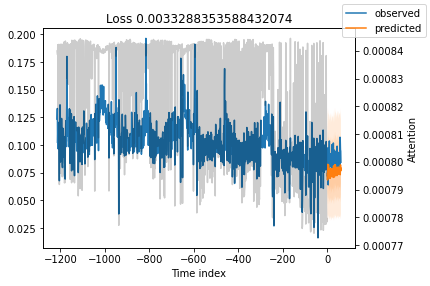

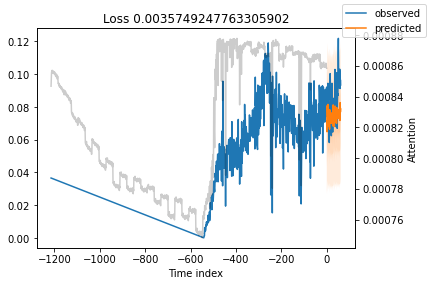

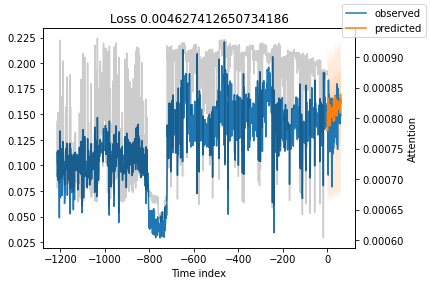

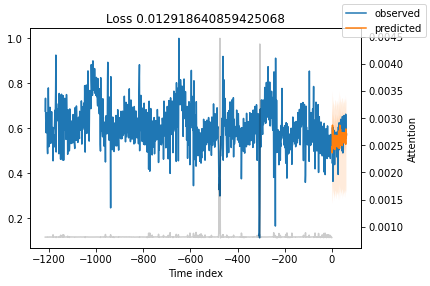

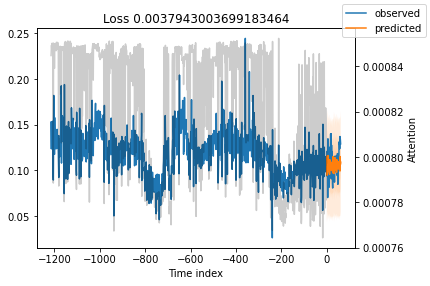

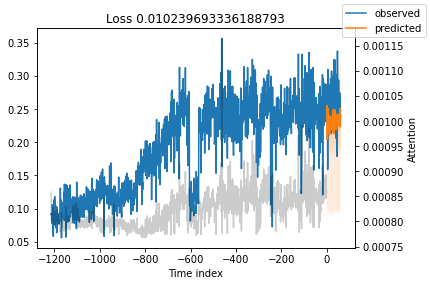

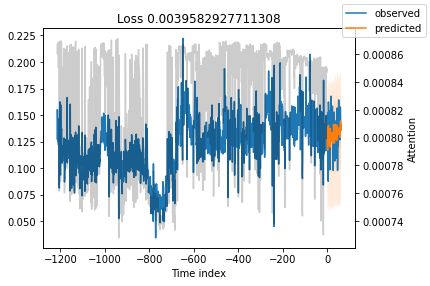

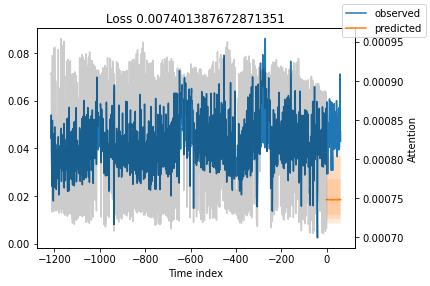

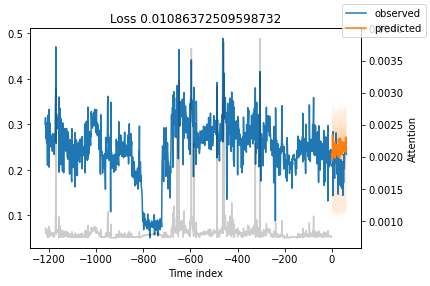

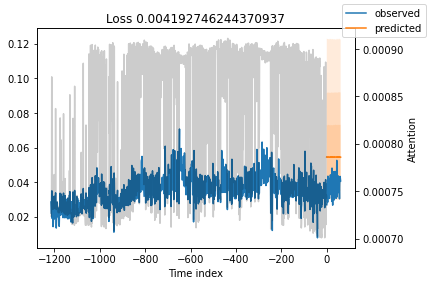

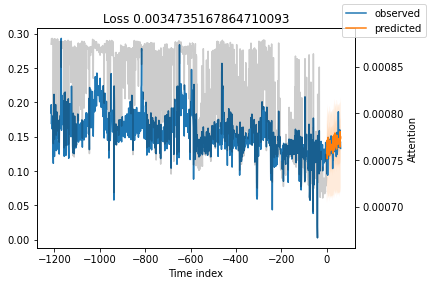

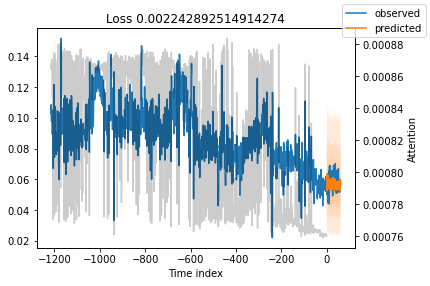

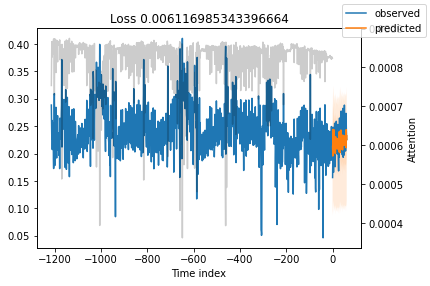

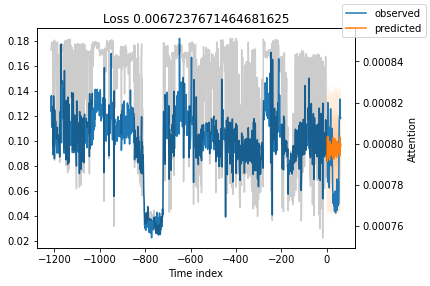

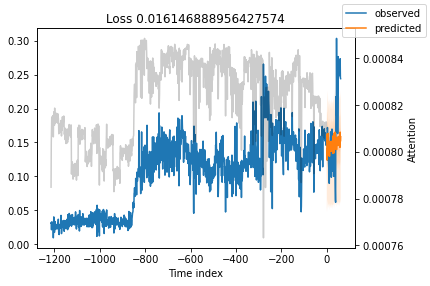

In [ ]:
for idx in range(15): 
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

### Actuals vs predictions by variables

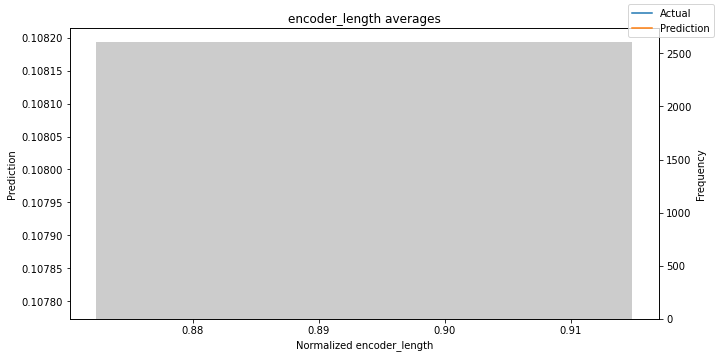

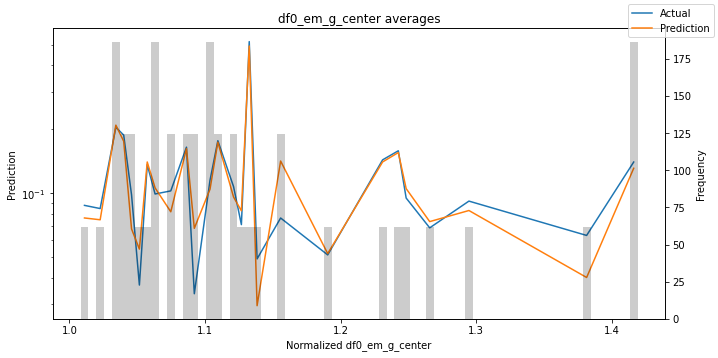

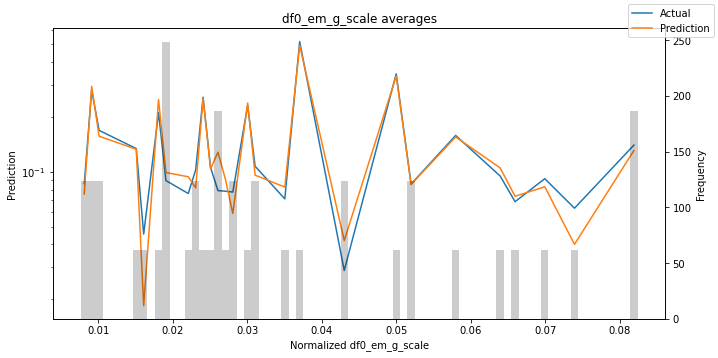

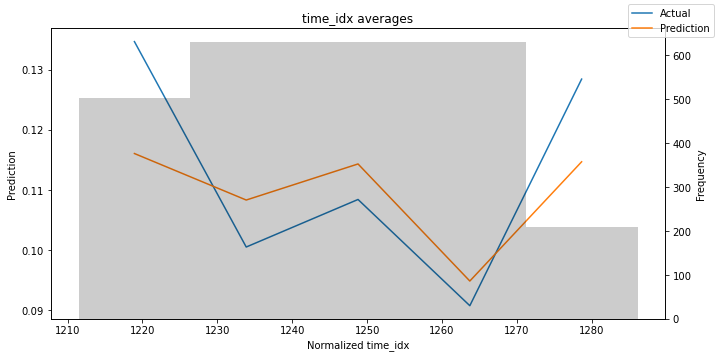

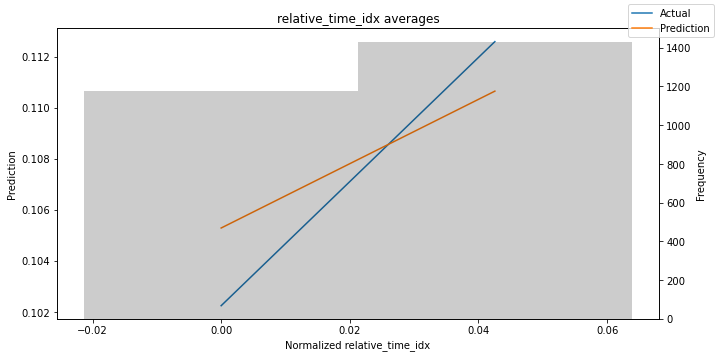

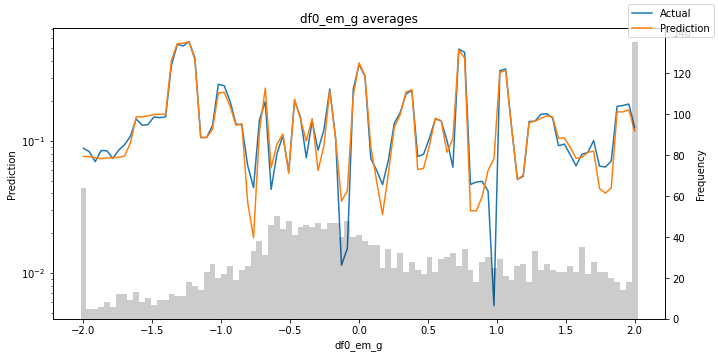

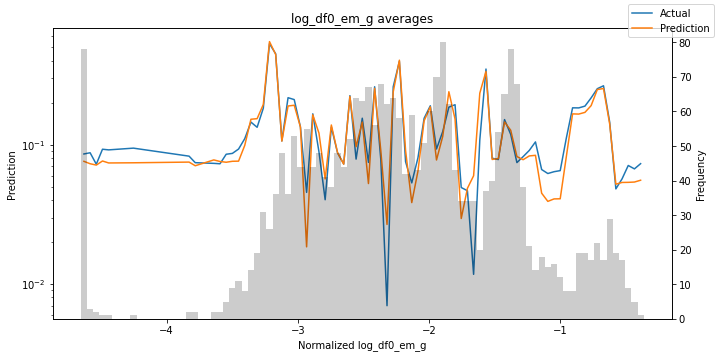

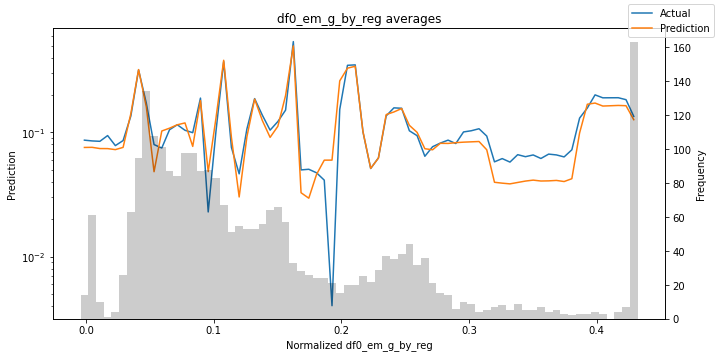

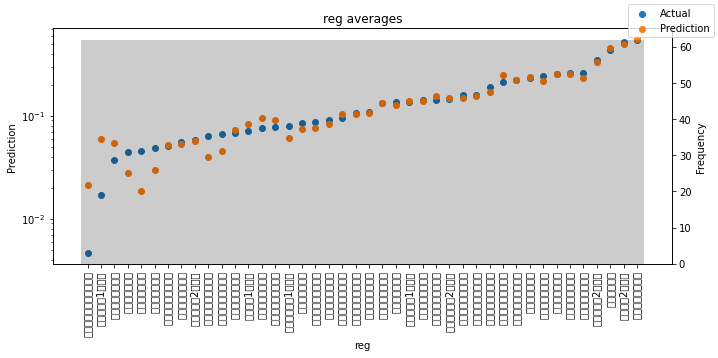

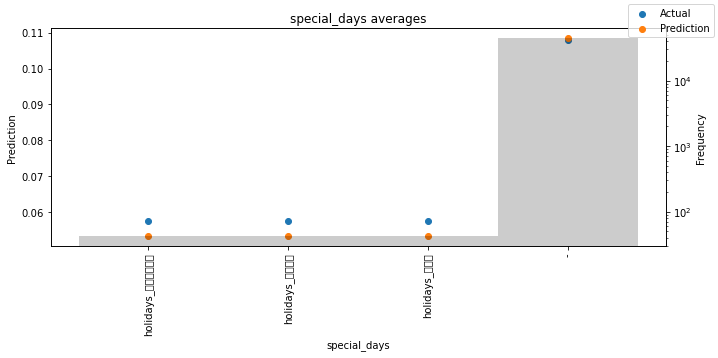

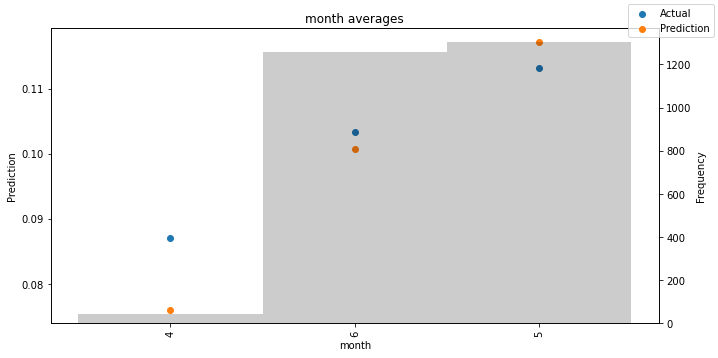

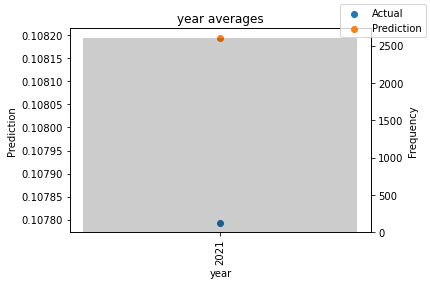

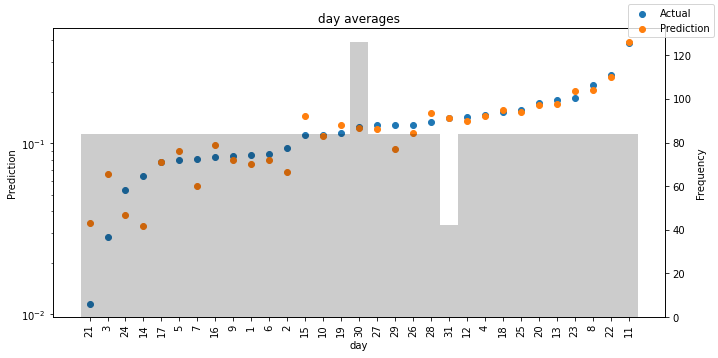

In [ ]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

## Predict on selected data

In [ ]:
best_tft.predict(
    training,
    mode="quantiles",
)

tensor([[[0.0318, 0.0468, 0.0564,  ..., 0.0863, 0.0995, 0.1202],
         [0.0382, 0.0557, 0.0666,  ..., 0.0991, 0.1126, 0.1337],
         [0.0292, 0.0431, 0.0520,  ..., 0.0811, 0.0937, 0.1140],
         ...,
         [0.0300, 0.0443, 0.0534,  ..., 0.0828, 0.0957, 0.1164],
         [0.0350, 0.0513, 0.0615,  ..., 0.0932, 0.1063, 0.1274],
         [0.0319, 0.0470, 0.0565,  ..., 0.0867, 0.0998, 0.1207]],

        [[0.0318, 0.0468, 0.0564,  ..., 0.0863, 0.0995, 0.1203],
         [0.0382, 0.0557, 0.0666,  ..., 0.0991, 0.1126, 0.1337],
         [0.0292, 0.0431, 0.0520,  ..., 0.0811, 0.0937, 0.1140],
         ...,
         [0.0300, 0.0443, 0.0534,  ..., 0.0828, 0.0957, 0.1164],
         [0.0350, 0.0513, 0.0615,  ..., 0.0932, 0.1063, 0.1274],
         [0.0319, 0.0470, 0.0565,  ..., 0.0867, 0.0998, 0.1207]],

        [[0.0318, 0.0468, 0.0564,  ..., 0.0863, 0.0995, 0.1203],
         [0.0382, 0.0557, 0.0666,  ..., 0.0991, 0.1126, 0.1337],
         [0.0292, 0.0431, 0.0520,  ..., 0.0811, 0.0937, 0.

## Predict on new data

In [ ]:
encoder_data = data[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

last_data = data[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
    [last_data.assign(date=lambda x: x.base_date + pd.offsets.MonthBegin(i)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)

decoder_data['time_idx'] = decoder_data['base_date'].dt.date.apply(lambda x : len(date_range("2018-01-01",str(x))))
decoder_data["time_idx"] += encoder_data["time_idx"].max() + 1 - decoder_data["time_idx"].min()

decoder_data["month"] = decoder_data.date.dt.month.astype(str).astype("category") 
decoder_data["day"] = decoder_data.date.dt.day.astype(str).astype("category")

new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

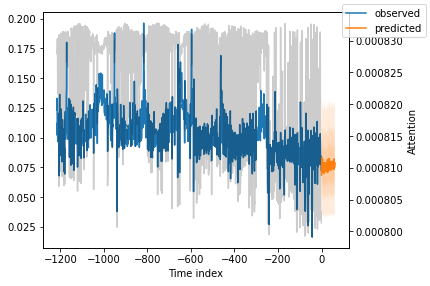

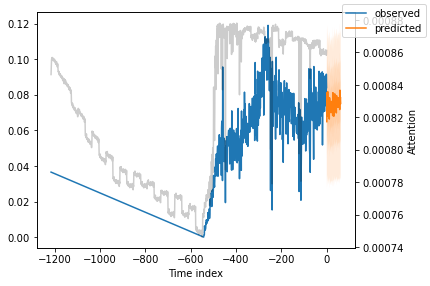

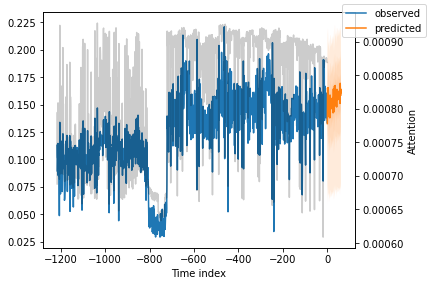

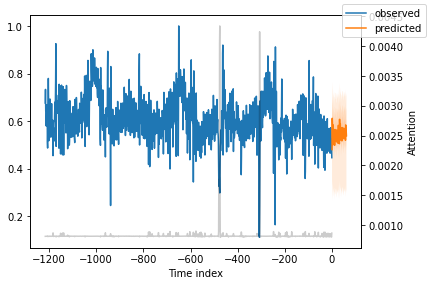

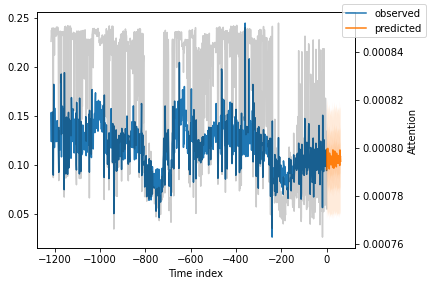

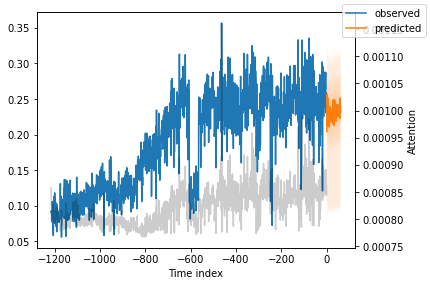

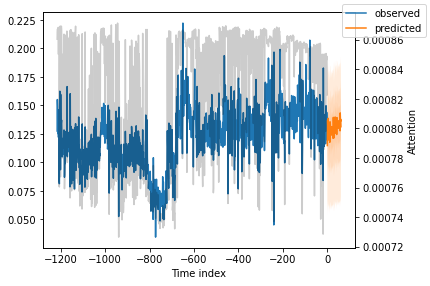

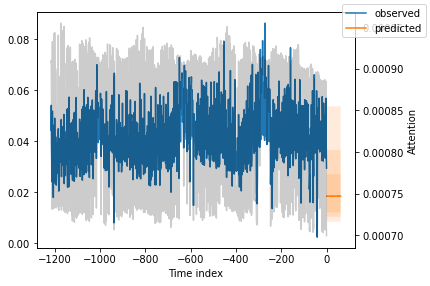

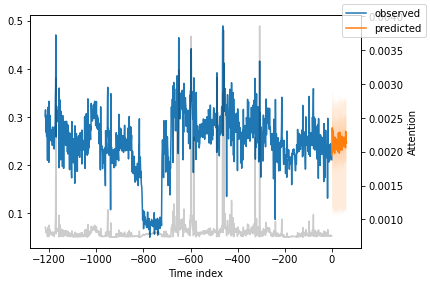

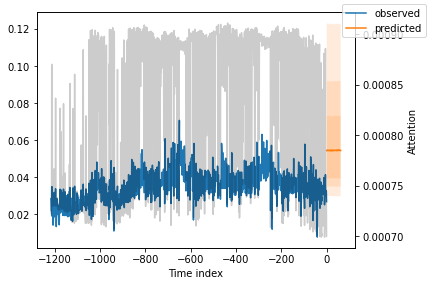

In [ ]:
new_raw_predictions, new_x = best_tft.predict(new_prediction_data, mode="raw", return_x=True)

for idx in range(10):  
    best_tft.plot_prediction(new_x, new_raw_predictions, idx=idx, show_future_observed=False);

In [ ]:
import joblib 

# 역스케일링
target = new_x['decoder_target']
ans = pd.DataFrame()
for i in range(42):
    reg_name = decoder_data['reg'][:42][i]   
    july_aug = list(new_x['decoder_target'][i])

    #역스케일링 scaler_clip_emg_minmax.pkl
    obj = joblib.load('./scaler_clip_emg_minmax.pkl') 
    after_scaler = obj.inverse_transform(np.array(july_aug).reshape(-1, 1))
    after_scaler = after_scaler.squeeze(1)
    after_scaler = [round(i,2) for i in after_scaler]
    
    ans[reg_name] = after_scaler
# ans.to_csv('dates_TFT_res.csv')
ans

,건입동,구좌읍,남원읍,노형동,대륜동,대정읍,대천동,도두동,동홍동,봉개동,...,정방동,조천읍,중문동,중앙동,천지동,표선면,한경면,한림읍,화북동,효돈동
0,9.760740e+05,1.027893e+06,1.488712e+06,5528173.5,1059379.625,3135057.000,1328341.625,466294.56250,2311220.25,310071.18750,...,594132.00000,1681414.500,1745595.000,1.179889e+06,875132.7500,1141719.125,631738.3750,2006181.875,2447875.25,663949.37500
1,1.086195e+06,9.193826e+05,1.628991e+06,6724813.0,1348513.750,2912680.000,1698607.000,664190.93750,2606152.25,439358.12500,...,540299.37500,1684031.625,1933707.250,1.095537e+06,860557.2500,1203403.125,604036.8750,2056390.875,2927739.00,688590.81250
2,9.105648e+05,9.592840e+05,1.786704e+06,5922436.0,1330757.375,3021191.000,1547376.500,559948.06250,2590328.50,372922.90625,...,550566.62500,1844080.125,1886759.625,1.102422e+06,823554.9375,1030309.250,694912.1875,2033561.250,2900641.25,703367.62500
3,7.139972e+05,7.297001e+05,1.010218e+06,4053996.5,782928.750,1772732.625,977966.375,326861.18750,1598390.50,316835.50000,...,390880.53125,1403715.375,1183835.000,7.982289e+05,550002.9375,654970.500,400262.0000,1292506.875,2327647.75,476279.96875
4,1.077096e+06,1.052535e+06,2.047493e+06,6728878.5,1499583.375,3451731.250,1809856.000,490452.81250,3166986.00,484695.09375,...,645951.43750,1902221.000,1923037.250,1.421633e+06,916523.8125,1178882.500,898364.9375,2594314.750,3058395.00,829876.31250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,1.164871e+06,1.113011e+06,1.846415e+06,7386466.5,1527123.625,2852043.000,1757231.250,794927.25000,3018332.25,466455.59375,...,706226.31250,1854468.125,2021441.875,9.350854e+05,850813.5000,1194062.000,700227.0625,1805185.250,3381350.50,798953.75000
58,1.065822e+06,1.017304e+06,1.764881e+06,6662967.5,1513474.375,2917753.500,1749017.500,486426.43750,2895245.75,482762.46875,...,708682.37500,1861594.875,1942001.500,1.073995e+06,884554.3750,1273864.750,845015.5000,2500781.750,3143754.00,770567.75000
59,1.055434e+06,1.076331e+06,1.668812e+06,6547249.5,1481786.750,2786453.000,1511944.375,527576.00000,2839722.00,466858.25000,...,683759.12500,1817747.625,1747849.625,1.108985e+06,874730.1875,1089174.875,772943.2500,2200897.500,2963976.25,725150.25000
60,9.420511e+05,1.040899e+06,1.657417e+06,6363284.5,1437738.250,2768012.500,1562998.750,480789.53125,2612916.50,453611.53125,...,746168.00000,1751835.875,1692044.125,1.160683e+06,862409.3750,1109226.250,784217.1875,2655878.000,3019459.50,814173.43750


## Interpret model

### Variable importances

{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x216 with 1 Axes>,
 'encoder_variables': <Figure size 504x306 with 1 Axes>,
 'decoder_variables': <Figure size 504x252 with 1 Axes>}

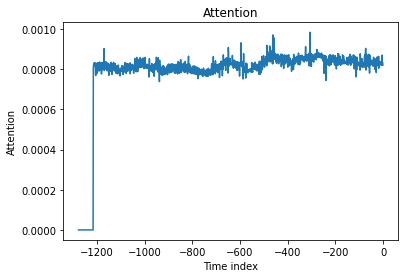

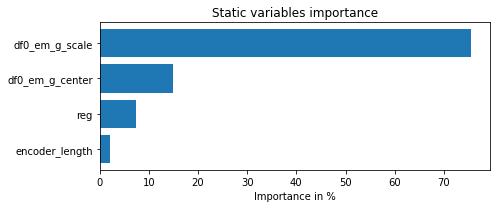

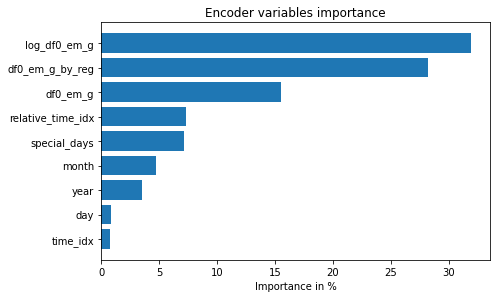

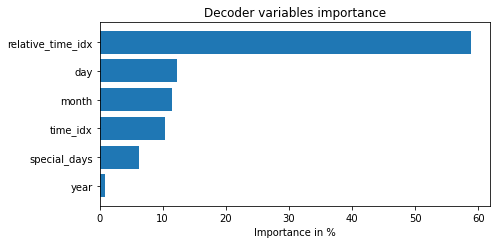

In [ ]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)